In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from subprocess import Popen, PIPE
from math import pi
from matplotlib import animation, rc, patches
from IPython.display import HTML
import ipywidgets as widgets
from IPython.display import display, clear_output
import io
import base64
import os.path

In [59]:
def run(magnitude, frequency, init_phase, init_angle, init_angular_speed, step, step_count):
    args = map(str, [
        "./console/bin/integr",
        magnitude,
        frequency,
        init_phase,
        1, # == bar_length,
        init_angle,
        init_angular_speed,
        step,
        step_count,
        "binary",
    ])
    proc = Popen(
        args=args,
        stderr=PIPE,
        stdout=PIPE,
    )
    out, err = proc.communicate()
    return np.frombuffer(out)

In [117]:
def get_is_stable(frequencies, init_angular_speeds):
    is_stable_matrix = np.zeros((len(frequencies), len(init_angular_speeds)))
    for i, freq in enumerate(frequencies):
        for j, init_speed in enumerate(init_angular_speeds):
            res = run(
                magnitude=0.1,
                frequency=freq,
                init_phase=0,
                init_angle=pi,
                init_angular_speed=init_speed,
                step=0.001,
                step_count=50000,
            )
            is_stable = np.all(np.logical_and(pi/2 <= res, res <= 3*pi/2))
            is_stable_matrix[i,j] = is_stable
    return is_stable_matrix

In [135]:
def plot_stability(matrix=None):
    min_freq, max_freq, step_freq = 40, 60, 60
    min_sp, max_sp, step_sp = 0.01, 2, 60
    frequencies = np.linspace(min_freq, max_freq, step_freq)
    init_angular_speeds = np.linspace(min_sp, max_sp, step_sp)
    if matrix is None:
        matrix = get_is_stable(frequencies=frequencies, init_angular_speeds=init_angular_speeds)
    plt.figure(figsize=(10,7))
    plt.pcolormesh(init_angular_speeds, frequencies, matrix)
    plt.xlabel("Initial angular speed, rad/s",fontsize='large')
    plt.ylabel("Support point frequency, rad/s", fontsize='large')
    return matrix

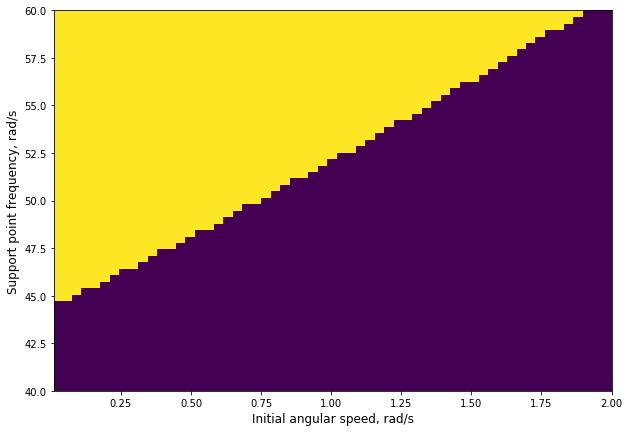

In [136]:
res = plot_stability(res)
plt.savefig('stabilization.png')

In [132]:
plt.savefig('a.png')

<Figure size 432x288 with 0 Axes>

In [26]:
default_step = 0.001
default_step_count = 50000
default_max_time = default_step_count * default_step
own_freq = (9.8/1)**(0.5)

In [27]:
def print_args(args):
    print(
        "Support point\n"
        "  Frequency: {frequency} rad/s\n"
        "  Magnitude: {magnitude} m\n"
        "  Initial phase: {init_phase} rad\n"
        "Pendulum\n"
        "  Initial angle: {init_angle} rad\n"
        "  Initial velocity: {init_angular_speed} rad/s"
        .format(**args))

def get_supp_xy(args, time):
    return (0, args["magnitude"] * np.sin(time * args["frequency"] + args["init_phase"]))

def make_animation(args, frames):    
    arr = run(**args)
    fig, (ax_draw, ax_plot) = plt.subplots(nrows=1, ncols=2, figsize=(16,4), gridspec_kw = {'width_ratios':[1, 3]})
    
    eff_mag = 1.1 + args["magnitude"]
    ax_draw.set_xlabel("x")
    ax_draw.set_ylabel("y")
    ax_draw.set_xlim((-eff_mag, eff_mag))
    ax_draw.set_ylim((-eff_mag, eff_mag))
    mass = patches.Ellipse(xy=(0,0), width=0.1, height=0.1)
    ax_draw.add_patch(mass)
    pend_line, = ax_draw.plot([], [], lw=3)
    supp_line, = ax_draw.plot([], [], lw=2, c='g', ls='--')
    
    max_time = args["step"] * args["step_count"]
    ax_plot.set_xlabel("Time, sec")
    ax_plot.set_ylabel("Angle, rad")
    ax_plot.set_xlim((-max_time*0.1, max_time*1.1))
    ax_plot.set_ylim((np.min(arr) - abs(np.min(arr)) * 0.1, np.max(arr) + abs(np.max(arr)) * 0.1))
    plot_line, = ax_plot.plot([], [], lw=2)
    
    artists = (plot_line, pend_line,supp_line,mass)
    
    def init():
        plot_line.set_data([], [])
        pend_line.set_data([], [])
        supp_line.set_data([], [])
        return artists
    
    steps_per_frame = args["step_count"] // frames
    
    def animate(i):
        i = (i + 1) * steps_per_frame
        plot_line.set_data(np.linspace(0, i * args["step"], i), arr[:i])
        supp_xy = get_supp_xy(args, i * args["step"])
        rel_mass_xy = (np.sin(arr[i-1]), -np.cos(arr[i-1]))
        mass_xy = (supp_xy[0] + rel_mass_xy[0], supp_xy[1] + rel_mass_xy[1])
        pend_line.set_data([mass_xy[0], supp_xy[0]], [mass_xy[1], supp_xy[1]])
        supp_line.set_data([0, 0], [-args["magnitude"], args["magnitude"]])
        mass.set_center(mass_xy)
        return artists
        
    anim = animation.FuncAnimation(
        fig,
        animate,
        init_func=init,
        frames=frames,
        interval=max_time / frames * 1000,
        blit=True,
    )
    plt.close(fig)
    return anim

def make_or_load_video(args, name):
    print_args(args)
    name = "videos/{}.mp4".format(name)
    if not os.path.isfile(name):
        anim = make_animation(args, frames=1000)
        anim.save(name, "ffmpeg")
    
    with io.open(name, "r+b") as f:
        video = f.read()
        encoded = base64.b64encode(video)
        return HTML(data='''
            <video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>
            '''.format(encoded.decode('ascii'))
        )

### Модель маятника Капицы
Рассматривается физический маятник с лёгкой нерастяжимой спицей длины $\ell$, прикреплённой одним концом к
подвижной точке подвеса, совершающей вертикальные колебания по закону $y = a \sin(\omega t + \gamma)$.
Система параметризуется одной обобщённой координатой $\varphi$ -- углом отклонения спицы от вертикали.

Запишем кинетическую и потенциальную энергию системы через $\varphi$, $\dot{\varphi}$ и $t$.
$$
E_K = \frac{m}{2}\left([\ell\cos\varphi\dot{\varphi}]^2 + [\ell\sin\varphi\dot{\varphi} + \omega a \cos(\omega t + \gamma)]^2\right)
$$
$$
E_P = mg(-\ell\cos\varphi + a\cos(\omega t + \gamma))
$$

Уравнения Эйлера-Лагранжа для Лагранжиана $L = E_K - E_P$:
$$
\frac{\partial L}{\partial \varphi} = \frac{d}{dt}\left(\frac{\partial L}{\partial \dot{\varphi}}\right)
$$
После упрощения приходим к виду:
$$
\ddot{\varphi} = \frac{\sin\varphi}{\ell}(\omega^2a\sin(\omega t + \gamma) - g)
$$

### Численное моделирование
Моделирование проводилось методом Рунге-Кутты 4-го порядка для системы ОДУ
$$
\begin{cases}
\dot{\varphi} = \psi \\
\dot{\psi} = \frac{\sin\varphi}{\ell}(\omega^2a\sin(\omega t + \gamma) - g) 
\end{cases}
$$

### Результаты для характерных наборов параметров
#### Неподвижный подвес, $E_{K0} < 2mg\ell$.

In [ ]:
args = {
    "magnitude": 0,
    "frequency": 0, 
    "init_phase": 0,
    "init_angle": 0,
    "init_angular_speed": 3,
    "step": default_step,
    "step_count": 20000,
}
make_or_load_video(args, "stable_support_small")

#### Неподвижный подвес, $E_{K0} = 2mg\ell - \varepsilon$. 

In [ ]:
args = {
    "magnitude": 0,
    "frequency": 0, 
    "init_phase": 0,
    "init_angle": 0,
    "init_angular_speed": 2*9.8**0.5 - 1e-15,
    "step": default_step,
    "step_count": default_step_count,
}
make_or_load_video(args, "stable_support_almost_equal")

#### Неподвижный подвес, $E_{K0} > 2mg\ell$. 

In [ ]:
args = {
    "magnitude": 0,
    "frequency": 0, 
    "init_phase": 0,
    "init_angle": 0,
    "init_angular_speed": 2*9.8**0.5 + 0.01,
    "step": default_step,
    "step_count": 30000,
}
make_or_load_video(args, "stable_support_large")

#### Раскачка (резонанс)
Частота колебаний подвеса $\omega$ вдвое превосходит собственную частоту маятника $\sqrt{\frac{g}{\ell}}$.

In [ ]:
args = {
    "magnitude": 0.1,
    "frequency": 2 * own_freq, 
    "init_phase": 0,
    "init_angle": 0,
    "init_angular_speed": 0.1,
    "step": default_step,
    "step_count": default_step_count,
}
make_or_load_video(args, "amplification")

#### Устойчивость в вертикальном положении (высокая частота колебаний подвеса)

In [29]:
args = {
    "magnitude": 0.1,
    "frequency": 50, 
    "init_phase": 0,
    "init_angle": pi,
    "init_angular_speed": 0.2,
    "step": default_step,
    "step_count": 10000,
}
make_or_load_video(args, "vertical_stability")

Support point
  Frequency: 50 rad/s
  Magnitude: 0.1 m
  Initial phase: 0 rad
Pendulum
  Initial angle: 3.141592653589793 rad
  Initial velocity: 0.2 rad/s


#### Фазовый захват (частота колебаний подвеса кратна собственной)

In [ ]:
args = {
    "magnitude": 0.1,
    "frequency": own_freq * 3, 
    "init_phase": 0,
    "init_angle": 0,
    "init_angular_speed": 1,
    "step": default_step,
    "step_count": default_step_count,
}
make_or_load_video(args, "phase_lock")

### Промоделируй свой маятник!

In [131]:
def make_control_widgets():
    return {
        "magnitude": widgets.FloatSlider(min=0, max=1, step=0.05, description="Supp. magnitude"),
        "frequency": widgets.FloatSlider(min=0, max=100, step=0.1, description="Supp. freq"),
        "init_phase": widgets.FloatSlider(min=-pi, max=pi, step=0.01, description="Supp. phase"),
        "init_angle": widgets.widgets.FloatSlider(min=-pi, max=pi, step=0.01, description="Init. angle"),
        "init_angular_speed": widgets.widgets.FloatSlider(min=0, max=10, step=0.01, description="Init. velocity"),
    }

args = {"step": default_step, "step_count": 15000}
wids = make_control_widgets()
run_wid = widgets.Button(description="Run modelling")
out_wid = widgets.Output()
for wid in list(wids.values()) + [run_wid, out_wid]:
    display(wid)

def update(event):
    for name, wid in wids.items():
        args[name] = wid.value
    with out_wid:
        clear_output()
        anim = make_animation(args, frames=150)
        display(HTML(anim.to_html5_video()))
        
run_wid.on_click(update)

FloatSlider(value=0.0, description='Supp. freq')

FloatSlider(value=0.0, description='Supp. magnitude', max=1.0, step=0.05)

FloatSlider(value=0.0, description='Init. angle', max=3.141592653589793, min=-3.141592653589793, step=0.01)

FloatSlider(value=0.0, description='Init. velocity', max=10.0, step=0.01)

FloatSlider(value=0.0, description='Supp. phase', max=3.141592653589793, min=-3.141592653589793, step=0.01)

Button(description='Run modelling', style=ButtonStyle())

Output()